<h1> Calculating the Mean NDVI Over Time Using Sentinel 2 Images <h1>

<p>WEkEO is the EU Copernicus DIAS (Data and Information Access Service) reference service for environmental data, virtual processing environments and skilled user support.</p>

<p>WEkEO offers access to a variety of data, including different parameters sensored from Sentinel-1, Sentinel-2 and Sentinel-3. It further offers access to climate reanalysis and seasonal forecast data.</p>

The Harmonised Data Access (HDA) API, a REST interface, allows users to subset and download datasets from WEkEO

This Jupyter notebook guides you in a friendly way to select the geographic are, the time range of interest and the cloud cover percentage. When the user offers these parameters the notebook will retrieve the sentinel 2 images from Wekeo and then it will calculate the NDVI index for each date. Lastlt it will plot the mean ndvi value over time on the screen.The steps are the following:
<ul>
    <li><b>Credentials Configuration</b></li>
    <li><b>Select the Area of Interest</b></li>
    <li><b>Select a Date Range</b></li>
    <li><b>Select Cloud Cover Percentage</b></li>
    <li><b>Retrieve Data from Wekeo</b></li>
    <li><b>Unzip the Downloaded Sentinel 2 Tiles</b></li>
    <li><b>Walk through the Sentinel 2 unzipped foders and create NDVI images</b></li>
    <li><b>Read all the created NDVI files and calculate the mean image</b> </li>
    <li><b>Plot the Mean NDVI</b></li>
</ul>

In [4]:
import os
import numpy as np                            # scientific comupting
import json                                   # JSON encoder and decoder
import glob
import time                                   # time assessment
import pandas as pd
import folium                                 # visualization
from folium import plugins                    # visualization
from folium.plugins import MiniMap, Draw, Search # visualization
from IPython.display import display           # visualization
from datetime import date
from basemaps import basemaps
import geopandas as gpd
import ipywidgets
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets
import geopandas
import sys
from IPython.core.display import HTML
import warnings
warnings.filterwarnings('ignore')
# Load helper functions
from hda_api_functions import *
#import required libraries
import rasterio
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime

# Credentials Configuration

In [5]:
# your WEkEO API username and password (needs to be in '  ')
user_name = 'kostas91'
password = ''

api_key = generate_api_key(user_name, password)
display(HTML('Your API key is: <b>'+api_key+'</b>'))

# Declare Dataset id. In this application we area using Sentinel 2 Level 2A products only.
dataset_id ="EO:ESA:DAT:SENTINEL-2:MSI"

# Enter here the directory path where you want to download the data to.
download_dir_path = os.getcwd() + "/data"

hda_dict = init(dataset_id, api_key, download_dir_path)

hda_dict = get_access_token(hda_dict)

# Accept Terms and Conditions (if applicable)
hda_dict = acceptTandC(hda_dict)

Getting an access token. This token is valid for one hour only.
Success: Access token is edfc846c-f111-306e-9e6b-b66ddf3a486d
Copernicus_General_License Terms and Conditions already accepted


# Select the Area of Interest

In [6]:
# create map
f = folium.Figure(height=500)
m = folium.Map(location=[34.952743, 33.152671], zoom_start=4, control_scale=True).add_to(f)

# add custom basemap
basemaps['Google Satellite Hybrid'].add_to(m)

# add a layer control panel to the map
m.add_child(folium.LayerControl())

# add minimap
m.add_child(MiniMap(tile_layer=basemaps['Google Satellite'], position='bottomright'))

# add draw control
draw = Draw(export=True, filename='AOI_manual_%s.geojson' % str(date.today()), draw_options={'polygon': False,'polyline': False, 'circle': False, 'marker': False, 'circlemarker': False})
draw.add_to(m)
# data = io.BytesIO()
# m.save(draw, close_file=False)

# MousePosition
formatter = "function(num) {return L.Util.formatNum(num, 3) + ' º ';};"

plugins.MousePosition(position='topright',separator=' | ',empty_string='NaN',lng_first=True,num_digits=20,prefix='Coordinates:',
    lat_formatter=formatter,
    lng_formatter=formatter,
).add_to(m)

# display map
updater = display(f, display_id='m')

# Select a Date Range

In [7]:
# When selectinv a time range keep in mind that Sentinel 2 time frequency of image acquisition over the same are is 6 days. 
start_date = widgets.DatePicker(
    description='Start Sensing',
    disabled=False
)
end_date = widgets.DatePicker(
    description='End Sensing',
    disabled=False
)

instructions = ipywidgets.widgets.HTML('Define the sensing period time range:')
display(instructions)

widgets.HBox([start_date, end_date])

HTML(value='Define the sensing period time range:')

# Select Cloud Cover Percentage

In [8]:
# It is best to keep cloud cover percentage no hogher than 10%.
cloud = widgets.IntSlider(value=10,min=0,max=100,step=10, description="Percentage")
display(cloud)

IntSlider(value=10, description='Percentage', step=10)

In [9]:
# Load geometry from geojson file 
gjson = gpd.read_file("AOI_manual_"+str(date.today())+".geojson")
geomg = gjson["geometry"][0].bounds

n1 = geomg[0] 
n2 = geomg[1] 
n3 = geomg[2] 
n4 = geomg[3] 

from datetime import datetime

start_date2 = datetime.strftime(start_date.value,'%Y-%m-%d')
end_date2 = datetime.strftime(end_date.value,'%Y-%m-%d')

In [10]:
data = {
  "datasetId": "EO:ESA:DAT:SENTINEL-2:MSI",
  "boundingBoxValues": [
    {
      "name": "bbox",
      "bbox": [
        n1, 
        n2,
        n3, 
        n4  
      ]
    }
  ],
  "dateRangeSelectValues": [
    {
      "name": "position",
      "start": start_date2 + "T00:00:00.000Z",
      "end": end_date2 + "T00:00:00.000Z"
    }
  ],
  "stringChoiceValues": [
    {
      "name": "processingLevel",
      "value": "LEVEL2A"
    }
  ],
  "stringInputValues": [
    {
      "name": "cloudCover",
      "value": str(cloud.value)
    }
  ]
}

# Retrieve Data from Wekeo

In [11]:
# Initiate the request by assigning a job ID
hda_dict = get_job_id(hda_dict, data)

Query successfully submitted. Job ID is fNnRTYgBVHs4qtQXEZ5y2M1_2v0
Query successfully submitted. Status is running
Query successfully submitted. Status is running
Query successfully submitted. Status is running
Query successfully submitted. Status is completed


In [12]:
# Build list of file names to be ordered and downloaded
hda_dict = get_results_list(hda_dict)

************** Results *******************************
{
    "content": [
        {
            "downloadUri": null,
            "filename": "S2A_MSIL2A_20220722T092041_N0400_R093_T34SEJ_20220722T134859.zip",
            "order": null,
            "productInfo": {
                "datasetId": "EO:ESA:DAT:SENTINEL-2:MSI",
                "product": "S2A_MSIL2A_20220722T092041_N0400_R093_T34SEJ_20220722T134859.SAFE",
                "productEndDate": "2022-07-22T09:20:41.024000Z",
                "productStartDate": "2022-07-22T09:20:41.024000Z"
            },
            "size": 1226278149,
            "url": "8e532596-67c9-5f70-8003-348482e4a302/S2A_MSIL2A_20220722T092041_N0400_R093_T34SEJ_20220722T134859.zip"
        },
        {
            "downloadUri": null,
            "filename": "S2B_MSIL2A_20220717T091559_N0400_R093_T34SEJ_20220717T105427.zip",
            "order": null,
            "productInfo": {
                "datasetId": "EO:ESA:DAT:SENTINEL-2:MSI",
                "pro

In [13]:
# Create an `order ID` for each file to be downloaded
hda_dict = get_order_ids(hda_dict)

Query successfully submitted. Order ID is umiZinytDupNRizm2dS2lQ5N8yE
Query successfully submitted. Status is completed
Query successfully submitted. Order ID is gMrbsbsVghdAnVOZ5segNWrDtT4
Query successfully submitted. Status is completed
Query successfully submitted. Order ID is yXzU-6JCrFs05-FgEiDeKMTtqTw
Query successfully submitted. Status is completed


In [14]:
# Download requested data
hda_dict = download_data(hda_dict)

File size is:  1169.47 MB
[==================================================]     47.90 Mbps[ 1169.51] MB downloaded, 49050.23 kbps
Download complete...
Time Elapsed: 24.415405688 seconds
File size is:  1169.78 MB
[==================================================]     48.85 Mbps[ 1169.82] MB downloaded, 50018.87 kbps
Download complete...
Time Elapsed: 23.948922214 seconds
File size is:  1164.15 MB
[==================================================]     49.92 Mbps[ 1164.19] MB downloaded, 51116.54 kbps
Download complete...
Time Elapsed: 23.321802462999997 seconds


# Unzip the Downloaded Sentinel 2 Tiles

In [27]:
# After executing this cell the zipped folders will be erased.
import os, zipfile
cwd = os.getcwd()
dir_name = cwd+'/data'
extension = ".zip"

os.chdir(dir_name) # change directory from working dir to dir with files

for item in os.listdir(dir_name): # loop through items in dir
    if item.endswith(extension): # check for ".zip" extension
        file_name = os.path.abspath(item) # get full path of files
        zip_ref = zipfile.ZipFile(file_name) # create zipfile object
        zip_ref.extractall(dir_name) # extract file to dir
        zip_ref.close() # close file
        os.remove(file_name) # delete zipped file

# Walk through the Sentinel 2 unzipped foders and create NDVI images

In [37]:
# giving directory name
# folderdir  = '/home/kostas91/data/'
 
# giving file extension
ext = ('B04_10m.jp2','B08_10m.jp2') # The file extensions of band 3..XXX
 
# iterating over all files
for path, dirc, files in os.walk(dir_name):
    for name in files:
        if name.endswith(ext[0]) or name.endswith(ext[1]):
            if name.endswith(ext[0]):
                with rasterio.open(path+'/'+name) as red:
                    RED = red.read(1).astype(float)
            if name.endswith(ext[1]):
                with rasterio.open(path+'/'+name) as nir:
                    NIR = nir.read(1).astype(float)
                    ndvi = (NIR-RED)/(NIR+RED)
                    #export ndvi image
                    print("Exporting "+'NDVI_'+name[0:15]+'.tiff')
                    NDVI = rasterio.open(dir_name+'/NDVI_'+name[0:15]+'.tiff','w',driver='Gtiff',width=red.width, height=red.height,count=1,crs=red.crs,transform=red.transform,dtype=np.float32)
                    NDVI.write(ndvi,1)
                    NDVI.close()
            

Exporting NDVI_T34SEJ_20220722.tiff
Exporting NDVI_T34SEJ_20220702.tiff
Exporting NDVI_T34SEJ_20220717.tiff


# Read all the created NDVI files and calculate the mean image

In [42]:
from skimage.io import imread, imshow
# create a list of all available ndvi images
input_ndvi_images =[]
alist = []
for item in os.listdir(dir_name+'/'):
    if item.startswith('NDVI'):
        input_ndvi_images.append(item)
        image = imread(item)
        alist.append(image)

arr = np.dstack(alist)
ndvi_mean = arr.mean(axis=2)

# Plot the Mean NDVI

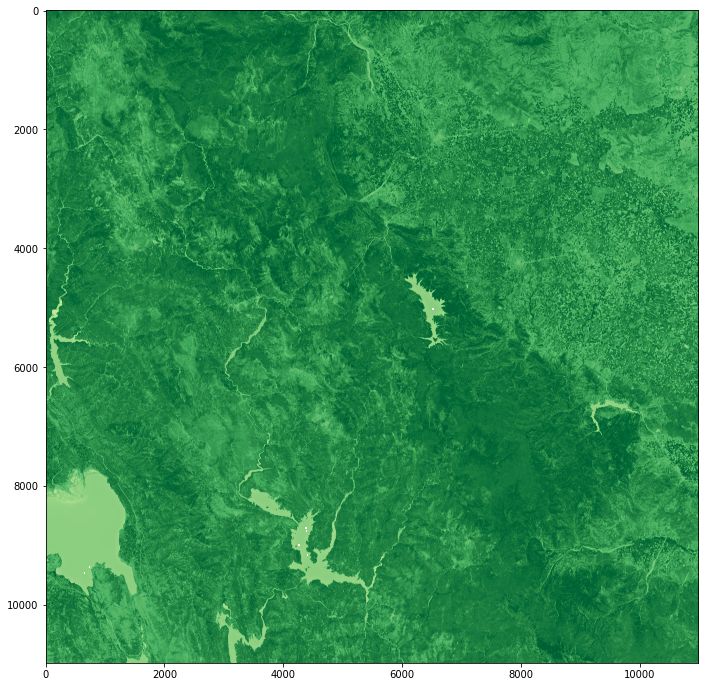

In [47]:
# It will some seconds to load
plt.figure(figsize=(12, 12))
plt.imshow(ndvi_mean, cmap='YlGn')